# Preparing your hysteresis data for HSOM-based analysis
This notebook illustrate the data preparation workflow required to use `HSOM` for both training SOMs or analysing data with a pretrained SOM (we'll use the [General T-Q SOM](https://egusphere.copernicus.org/preprints/2025/egusphere-2025-2146/)). The workflow will be illustrated using a time series of discharge and turbidity for which a set of hydrologic events where previously delineated. 
   
Beyond the `HySOM` dependencies (`numpy`, `matplotlib` and `numba`), `Pandas` is required to run this notebook, so make sure you have it installed.

In [1]:
from hysom.pretrainedSOM import get_generalTQSOM
from hysom.utils import datasets
from hysom.utils.plots import heatmap_frequency

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load time series and hydrologic events data

First, let's load a sample dataset included in the `HySOM` package. The dataset contains two main pices of data:  
1. 15-min discharge and turbidity data collected by the USGS [USGS-01191000](https://waterdata.usgs.gov/monitoring-location/USGS-01191000/#dataTypeId=continuous-00065-0&period=P365D&showFieldMeasurements=true) between 06/2016 and 12/2023.   
2. A list of hydrologic events defined by their start and end times.  
  
The data can be loaded with the function `get_watershed_timeseries` in `hysom.utils.datasets`   

In [6]:
QT = pd.DataFrame(datasets.get_01191000_qt_data())
QT.set_index("datetime", inplace=True, drop=True)
events = datasets.get_01191000_events_data()

## Visualize the data
The next plot shows the time series data and hydrologic events 

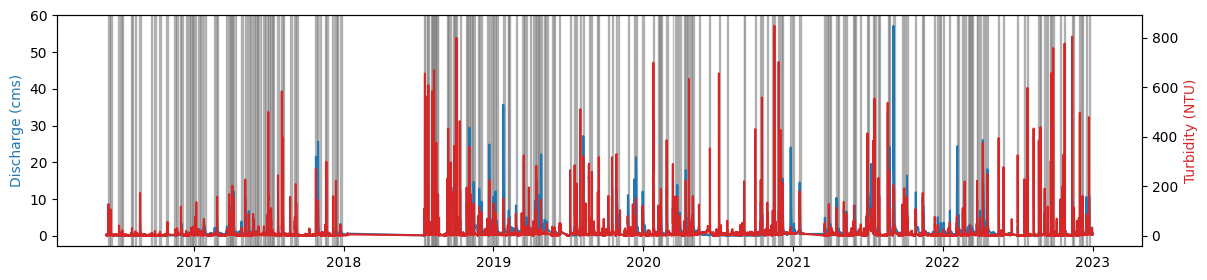

In [9]:
fig, axQ = plt.subplots(figsize = (14,3))
axQ.plot(QT["Qcms"])
axT = axQ.twinx()
axT.plot(QT["turb"], color = 'tab:red')

axQ.set_ylabel("Discharge (cms)", color = "tab:blue")
axT.set_ylabel("Turbidity (NTU)", color = "tab:red")

for start, end in events:
    axQ.axvspan(xmin = start, xmax=end, color = 'grey', alpha = 0.5)


## Extract hysteresis loops
First, let's extract the time series for the first event:

In [10]:
event_start, event_end = events[0] 
eventQT = QT.loc[event_start:event_end]
print(eventQT)

                               Qcms  turb
datetime                                 
2016-06-04 08:15:00+00:00  0.213226   2.3
2016-06-04 08:30:00+00:00  0.213226   2.4
2016-06-04 08:45:00+00:00  0.213226   2.4
2016-06-04 09:00:00+00:00  0.213226   2.4
2016-06-04 09:15:00+00:00  0.213226   2.4
...                             ...   ...
2016-06-09 05:00:00+00:00  0.472891   3.1
2016-06-09 05:15:00+00:00  0.472891   3.2
2016-06-09 05:30:00+00:00  0.472891   3.4
2016-06-09 05:45:00+00:00  0.472891   3.3
2016-06-09 06:00:00+00:00  0.472891   3.3

[457 rows x 2 columns]


### Sample plot of an event and its associated hysteresis loop

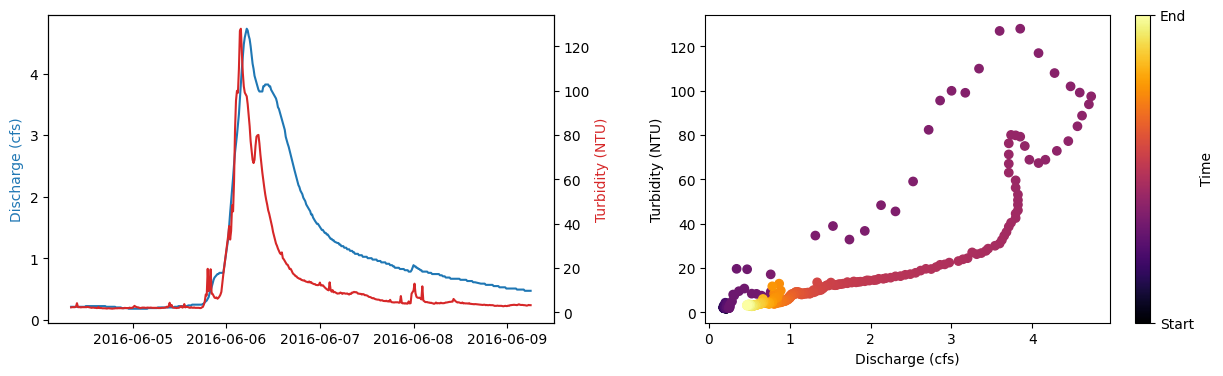

In [12]:
fig, (axQ, ax_loop) = plt.subplots(1,2, figsize = (15,4))

# Plot time series
axT = axQ.twinx()
axQ.plot(eventQT["Qcms"] ,'tab:blue')
axQ.set_ylabel("Discharge (cfs)", color = 'tab:blue')
axT.plot(eventQT["turb"], 'tab:red')
axT.set_ylabel("Turbidity (NTU)", color = 'tab:red')

# Plot loop
loop_mappable = ax_loop.scatter(eventQT["Qcms"], eventQT["turb"], cmap = "inferno", c = range(len(eventQT)))
ax_loop.set_xlabel("Discharge (cfs)")
ax_loop.set_ylabel("Turbidity (NTU)")

cb = plt.colorbar(loop_mappable)
cb.set_ticks(ticks = (0, len(eventQT)), labels = ("Start", "End") )
cb.set_label("Time")

plt.subplots_adjust(wspace=0.3)


## Make a hysteresis loop compatible with `HSOM`

A hysteresis loop is basically an ordered sequence of $(Discharge,Concentration)$ data pairs. However, the length of this sequence varies with the event duration and data frequency. Also, the range of values in this sequence can vary drastically between events and watersheds. Since `HSOM` aims to characterize hysteresis loops based on the loop shape regardless of the event magnitude and duration, two normalization steps are required. First, events should be rescaled to a common scale. Second, loop sequences should have a constant length for a given SOM.   
  
For example, trained data for the [General T-Q SOM](https://egusphere.copernicus.org/preprints/2025/egusphere-2025-2146/) was scaled to a [0,1] interval using min-max normalization and loop sequences were resampled to 100 data points. Hence, every loop fed into this model must undergo the same preprocessing.  

Let's see what this preprocessing looks like for the previously plotted event. First, I'll define a function to interpolate data in the $(Discharge, Concentration)$ plane (right panel in the figure above). The resulting (interpolated) data will be equally spaced in this plane 


In [13]:
def loop_interpolation(CQtimeSeries: pd.DataFrame, seq_length) -> np.ndarray:
    """
    Interpolates a hysteresis loop in the C-Q plane to make it compatible with `HSOM`. 
    The resulting loop will have `seq_length` evenly spaced data points.
    Note that the interpolation procedure ignores time information

    Parameters:
    - CQtimeSeries (pd.DataFrame): Pandas DataFrame with two columns. Typically: (discharge, concentration)
    - seq-length (int): number  
    
    Returns:
    - np.ndarray: Numpy array of shape seq_length x 2 with the interpolated sequence

    """
    col1, col2 = CQtimeSeries.columns
    accum_dists = ( (CQtimeSeries[col1] - CQtimeSeries.shift(1)[col1])**2 + (CQtimeSeries[col2] - CQtimeSeries.shift(1)[col2])**2).apply(np.sqrt).cumsum()
    accum_dists.iloc[0] = 0.0
    path_length = accum_dists.max()
    
    interp_dists = np.linspace(0,path_length, seq_length)
    
    col1_interp = np.interp(interp_dists, accum_dists, CQtimeSeries[col1])
    col2_interp = np.interp(interp_dists, accum_dists, CQtimeSeries[col2])
    
    return np.stack((col1_interp, col2_interp), axis = 1)

Now, let's apply min-max normalization and interpolate the sequence

In [18]:
original_event = eventQT
min_max_normalized_event = ( (original_event - original_event.min()) / (original_event.max() - original_event.min()) ).rename({"Qcms":"normQ", "turb":"normTurb"}, axis = "columns") # apply min-max normalization
interpolated_loop = loop_interpolation(CQtimeSeries = min_max_normalized_event, seq_length = 100) # interpolate loop in the (Q,C) plane 


Note that `interpolated_loop` is a numpy array:

In [20]:
print(f"{type(interpolated_loop)} of shape {interpolated_loop.shape}")

<class 'numpy.ndarray'> of shape (100, 2)


Let's visualize these transformartions

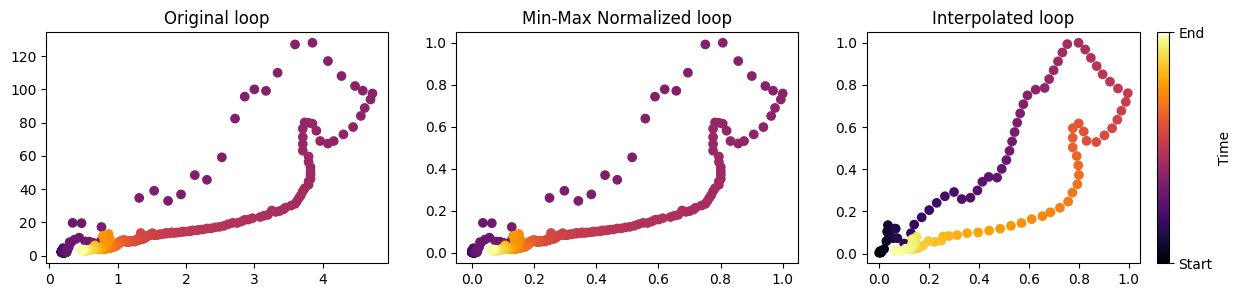

In [21]:
fig, (ax1, ax2, ax3)  =plt.subplots(1,3, figsize  =(15,3))

ax1.scatter(original_event["Qcms"], original_event["turb"], cmap = "inferno", c = range(len(original_event)))
ax1.set_title("Original loop")
ax2.scatter(min_max_normalized_event["normQ"], min_max_normalized_event["normTurb"], cmap = "inferno", c = range(len(min_max_normalized_event)))
ax2.set_title("Min-Max Normalized loop")
sc = ax3.scatter(interpolated_loop[:,0], interpolated_loop[:,1], cmap = "inferno", c = range(len(interpolated_loop)))
ax3.set_title("Interpolated loop")

cb = plt.colorbar(sc)
cb.set_ticks(ticks = (0, len(interpolated_loop)), labels = ("Start", "End") )
cb.set_label("Time")



## Preprocess the entire dataset

Our `interpolated_loop` is now compatible with `HSOM` and can be either part of a dataset for training an SOM or fed into a pretrained `HSOM`.   
  
Let's now apply the same preprocessing to the entire dataset: 

In [22]:
loops = []
for event in events:
    start, end = event[0], event[1]
    qtevent = QT[start:end]
    qtnormalized = (qtevent - qtevent.min()) / (qtevent.max() - qtevent.min())
    loops.append(loop_interpolation(qtnormalized, 100))



Our list of loops is now compatible with `HSOM`. 
  
Let's some loops

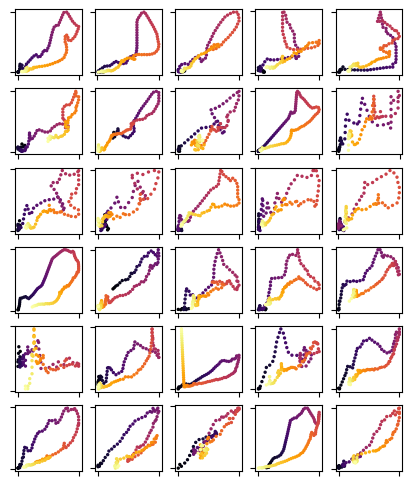

In [23]:
fig, axs = plt.subplots(6,5, figsize = (5,6))

for loop, ax in zip(loops, axs.flatten()):
    ax.scatter(loop[:,0], loop[:,1], cmap = "inferno", c = range(len(loop)), s = 2)
    ax.tick_params(labelbottom = False, labelleft = False)

## Feed preprocessed loops into a pre-trained SOM (General TQ-SOM)

Finally, let's classify these loops using the `General TQ-SOM`.  
Additional details on training an SOM can be found [here](https://hysom.readthedocs.io/en/latest/tutorials/thesomclass.html).  
For further details on visualization functions see [this](https://hysom.readthedocs.io/en/latest/tutorials/vizfunctions.html) 
For further details on the analysis using the General T-Q SOM, see [this](https://hysom.readthedocs.io/en/latest/tutorials/analyze_TQ_data.html)

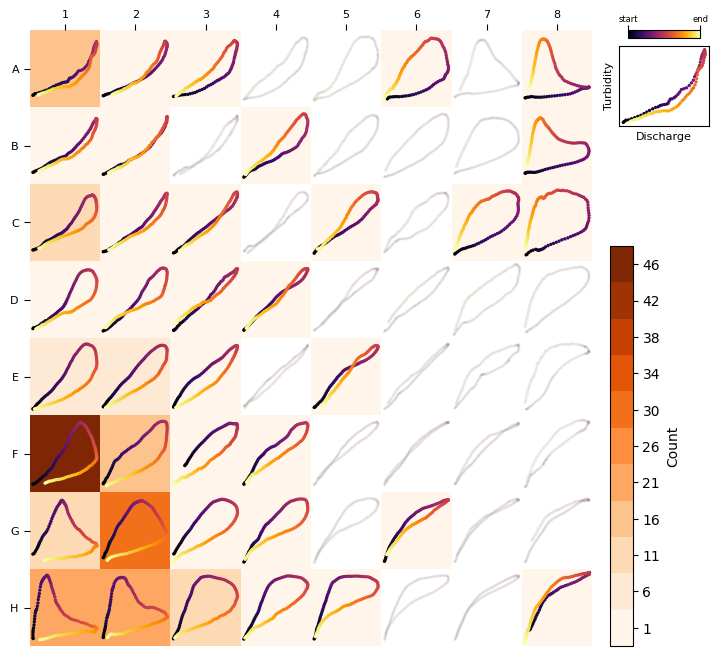

In [24]:
tqsom = get_generalTQSOM() # Load pre-trained SOM
heatmap_frequency(tqsom, loops) # Plot the frequency distribution of loop types 

### Finally let's compare some of the samples with their Best-Matching unit 

Text(0.5, 1.0, 'Best Matching\nUnit')

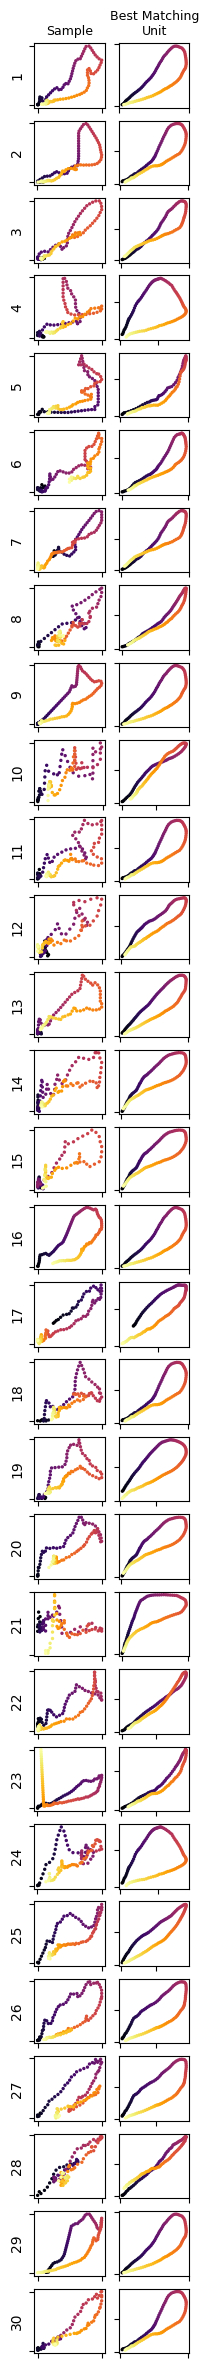

In [25]:
nloops = 30
fig, axs = plt.subplots(nloops, 2, figsize = (2, nloops))

for row, loop in enumerate(loops[:nloops]):
    bmu = tqsom.get_BMU(loop)
    prototype = tqsom.get_prototypes()[bmu]

    ax1, ax2 = axs[row]
    ax1.scatter(loop[:,0], loop[:,1], cmap = "inferno", c = range(len(loop)), s = 2)
    ax1.tick_params(labelbottom = False, labelleft = False)
    ax1.set_ylabel(row + 1)

    ax2.scatter(prototype[:,0], prototype[:,1], cmap = "inferno", c = range(len(loop)), s = 2)
    ax2.tick_params(labelbottom = False, labelleft = False)

    
axs[0,0].set_title("Sample", size = 9)
axs[0,1].set_title("Best Matching\nUnit", size = 9)

